In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import operator

# Music Analysis
Our data has various features on music that can be valuable. A few issues come with the data we get, though.<br>
First we create column names and create the Dataframe for the data.

In [61]:
columns = ['Artist', 'Title', 'Album', '#_of_views', 'Release_date', '#_feat_artists', 'Artist_pop', 'Genre', 
           'Followers', 'Danceability', 'Energy', 'Valence', 'Duration', 'Loudness', '#_words', 'Lyrics']
music_df = pd.read_csv('lyricDataset.scv', names = columns)
music_df.head()

,Artist,Title,Album,#_of_views,Release_date,#_feat_artists,Artist_pop,Genre,Followers,Danceability,Energy,Valence,Duration,Loudness,#_words,Lyrics
0,Miranda Lambert,Vice,The Weight of These Wings,42261,2016-07-18,0,74,contemporary country / country / country dawn ...,2184569,0.568,0.562,0.247,240280,-7.775,233,Sting of the needle dropping on a vinyl\nNeon ...
1,Miranda Lambert,Tin Man,The Weight of These Wings,40702,2016-11-18,0,74,contemporary country / country / country dawn ...,2184569,0.425,0.372,0.292,259280,-10.920,147,Hey there Mr. Tin Man\nYou don't know how luck...
2,Miranda Lambert,Little Red Wagon,Platinum,29992,2014-06-03,0,74,contemporary country / country / country dawn ...,2184569,0.584,0.813,0.774,204387,-7.221,255,You only love me for my big sunglasses\nAnd my...
3,Miranda Lambert,Mama’s Broken Heart,Four the Record,29986,2013-01-14,0,74,contemporary country / country / country dawn ...,2184569,0.768,0.809,0.748,177773,-4.204,315,I cut my bangs with some rusty kitchen scissor...
4,Miranda Lambert,Somethin’ Bad,Platinum,26966,2014-05-19,1,74,contemporary country / country / country dawn ...,2184569,0.777,0.245,0.349,109107,-14.266,307,Stand on the bar stomp your feet start clapp...


## Cleaning
The genre column is a little confusing. Most songs have more than one genre, with some of the genres being sub-genres. For instance, instead of `contemporary country`, we can replace that with `country`. The same goes for `pop-punk`, `metalcore`, `indie pop`, etc. <br>
Instead, we will bin the genres so that there are no sub-genres allowed. The only genres we want are `country`, `hip hop`, `pop`, `rock` and `metal`.

In [62]:
genres = music_df['Genre']
g_list = list(genres)
genre_list = ['country', 'hip hop', 'pop', 'rock', 'punk', 'metal', 'australian'] #Australian reggae is outlier

In [63]:
correct_guesses = {}
for index, genre in enumerate(g_list):
    if type(genre) == float:
        continue
    else:
        if len(genre) == 1:
            print(genre)
            split_genres = genre
        else:
            split_genres = genre.split(' / ') 
    for g in genre_list:
        correct = 0
        if len(split_genres) == 1 and split_genres[0] == 'rap':
            correct_guesses['hip hop'] = correct
        else:
            for split in split_genres:
                if g in split:
                    correct += 1
            correct_guesses[g] = correct
    
    correct_genre = max(correct_guesses, key=lambda key: correct_guesses[key])
    if correct_genre == 'australian':
        g_list[index] = 'pop'
    elif correct_genre == 'punk':
        g_list[index] = 'rock'
    else:
        g_list[index] = correct_genre
    correct_guesses.clear()

### Genre problems
Some songs have strange genres, so we will convert those to `pop`. Some of the weird genres are `australian psychadelic` and `australian reggae`. The artists that have these genre tags are `Sticky Fingers` and `Tame Impala`. As far as I know, those artists are quite popular.<br>
Below the new `corrected_genres` column is added, so only one genre is listed.

In [64]:
music_df['corrected_genres'] = g_list
music_df.head()

,Artist,Title,Album,#_of_views,Release_date,#_feat_artists,Artist_pop,Genre,Followers,Danceability,Energy,Valence,Duration,Loudness,#_words,Lyrics,corrected_genres
0,Miranda Lambert,Vice,The Weight of These Wings,42261,2016-07-18,0,74,contemporary country / country / country dawn ...,2184569,0.568,0.562,0.247,240280,-7.775,233,Sting of the needle dropping on a vinyl\nNeon ...,country
1,Miranda Lambert,Tin Man,The Weight of These Wings,40702,2016-11-18,0,74,contemporary country / country / country dawn ...,2184569,0.425,0.372,0.292,259280,-10.920,147,Hey there Mr. Tin Man\nYou don't know how luck...,country
2,Miranda Lambert,Little Red Wagon,Platinum,29992,2014-06-03,0,74,contemporary country / country / country dawn ...,2184569,0.584,0.813,0.774,204387,-7.221,255,You only love me for my big sunglasses\nAnd my...,country
3,Miranda Lambert,Mama’s Broken Heart,Four the Record,29986,2013-01-14,0,74,contemporary country / country / country dawn ...,2184569,0.768,0.809,0.748,177773,-4.204,315,I cut my bangs with some rusty kitchen scissor...,country
4,Miranda Lambert,Somethin’ Bad,Platinum,26966,2014-05-19,1,74,contemporary country / country / country dawn ...,2184569,0.777,0.245,0.349,109107,-14.266,307,Stand on the bar stomp your feet start clapp...,country


## Sentiment Analysis
Another column we want to add for analysis is the perceived sentiment of each lyric. Before we calculate the analysis, we need to clean up the lyric column. So, we remove punctuation and make everything lowercase. 

In [65]:
# Plot some stuff over time. Also, use sentiment
music_df['Lyrics'] = music_df['Lyrics'].astype(str)
music_df['Lyrics'] = music_df['Lyrics'].str.lower()
music_df['Lyrics'] = music_df['Lyrics'].str.translate(string.punctuation)
music_df['Lyrics'] = music_df['Lyrics'].str.replace('+', ' ').replace('\\', '').replace('"', '')

The library that calculates sentiment is called `vaderSentiment`. The description from the vader github states: VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.<br>
Since this is based on sentiments expressed in social media, it may not be the best. The next step to take after this analysis is to look into training our own model on lyrics. For now, we will work with this sentiment analysis.

In [66]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = []
analyzer = SentimentIntensityAnalyzer()
for label, content in music_df['Lyrics'].items():
    sentiment.append(analyzer.polarity_scores(content))

### Sentiments
There are 4 values this analyzer returns. The values are<br>
1. The perceived negativaty of the lyrics.
2. The perceived neutrality of the lyrics.
3. The perceived positivity of the lyrics.
4. The compound score that decides how negative, neutral and positive a lyric is.

For the negative, neutral and positive scores, the values range from `-1 to 1`.<br>
The compound value ranges from `-10 to 10`.

In [67]:
neg = []
neu = []
pos = []
compound = []

In [68]:
for sentiments in sentiment:
    neg.append(sentiments['neg'])
    neu.append(sentiments['neu'])
    pos.append(sentiments['pos'])
    compound.append(sentiments['compound'])

In [69]:
music_df['negative_score'] = neg
music_df['neutral_score'] = neu
music_df['positive_score'] = pos
music_df['compound_score'] = compound

In [70]:
music_df.head()

,Artist,Title,Album,#_of_views,Release_date,#_feat_artists,Artist_pop,Genre,Followers,Danceability,...,Valence,Duration,Loudness,#_words,Lyrics,corrected_genres,negative_score,neutral_score,positive_score,compound_score
0,Miranda Lambert,Vice,The Weight of These Wings,42261,2016-07-18,0,74,contemporary country / country / country dawn ...,2184569,0.568,...,0.247,240280,-7.775,233,sting of the needle dropping on a vinyl neon s...,country,0.034,0.868,0.098,0.9311
1,Miranda Lambert,Tin Man,The Weight of These Wings,40702,2016-11-18,0,74,contemporary country / country / country dawn ...,2184569,0.425,...,0.292,259280,-10.920,147,hey there mr. tin man you don't know how lucky...,country,0.124,0.781,0.094,-0.2295
2,Miranda Lambert,Little Red Wagon,Platinum,29992,2014-06-03,0,74,contemporary country / country / country dawn ...,2184569,0.584,...,0.774,204387,-7.221,255,you only love me for my big sunglasses and my ...,country,0.048,0.780,0.172,0.9901
3,Miranda Lambert,Mama’s Broken Heart,Four the Record,29986,2013-01-14,0,74,contemporary country / country / country dawn ...,2184569,0.768,...,0.748,177773,-4.204,315,i cut my bangs with some rusty kitchen scissor...,country,0.146,0.763,0.091,-0.9398
4,Miranda Lambert,Somethin’ Bad,Platinum,26966,2014-05-19,1,74,contemporary country / country / country dawn ...,2184569,0.777,...,0.349,109107,-14.266,307,stand on the bar stomp your feet start clapp...,country,0.174,0.661,0.165,-0.9289


## Various Genre Summaries
Now that we've decreased the number of genres per song to just one genre, we can begin some analysis. First we group the dataframe by the corrected genres.<br>
We can see `pop` has the most songs in this dataset, with `rock` having the least.

In [71]:
music_df['corrected_genres'].value_counts()

pop        500
hip hop    440
country    220
metal      220
rock       180
Name: corrected_genres, dtype: int64

In [75]:
genre_analyze = music_df.groupby(['corrected_genres'])

### Song Analytics
Below we will get averages of some features all songs have. Those features are:
1. How danceable a song is
2. How much energy a song has
3. The mood of a song
4. How loud a song is
5. How many words a song has
6. How long songs are

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe53773240>,
      dtype=object)

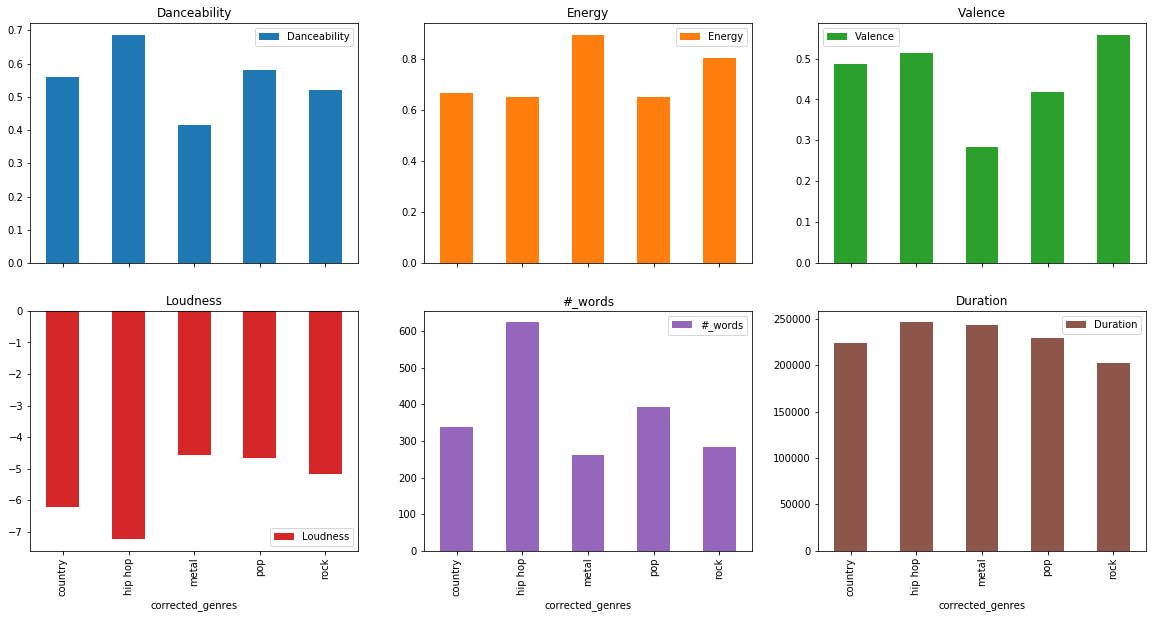

In [76]:
genre_analyze[['Danceability', 'Energy', 'Valence', 'Loudness', '#_words', 'Duration']].mean().plot.bar(subplots=True, layout=(3,3), figsize=(20,15))

We will go feature-by-feature for these charts, noting interesting statistics about each feature.

`Danceability`:
* As should be obvious, metal is the least danceable music amongst these genres.
* Hip-hop is the most danceable genre. I assume this is because of the bass and drums incorporated into many hip-hop songs
* Interestingly, country is almost as danceable as pop music. I can only imagine two stepping with country music

`Energy`:
* Metal has the most energy amongst these genres. Metal music usually has fast riffs and fast instrumentals.
* Rock would be the next highest energy.
* The last three seem to have around the same energy.

`Valence`:
* The most positive genre seems to be rock. I would assume pop would be more positive.
* The metal genre is the least positive, from the entire bunch. That makes sense, since metal music can be dark sometimes.
* Hip-hop is almost as positive as rock
* Something to note about this feature, is that the instrumentals are used to calculate valence as well.

`Loudness`:
* The higher the loudness, the more loud the music is.
* The most loud genre is metal. Next loudest is is pop.
* Hip-hop is the generally the least loud.

`Number of words`:
* Hip-hop has the highest average amount of words per song. Hip hop artists are usually lyricists.
* Even though hip hop artists have the highest word count, it could be repititions.
* The least wordy genre is metal. I assume this comes from metal being focused on instrumentals.

`Duration in milliseconds`:
* The duration is close to the same for each genre.
* Hip hop seems to have the highest duration.

## Sentiment Analytics
Now we will focus on the sentiments calculated by the vader library.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe51395cc0>,
      dtype=object)

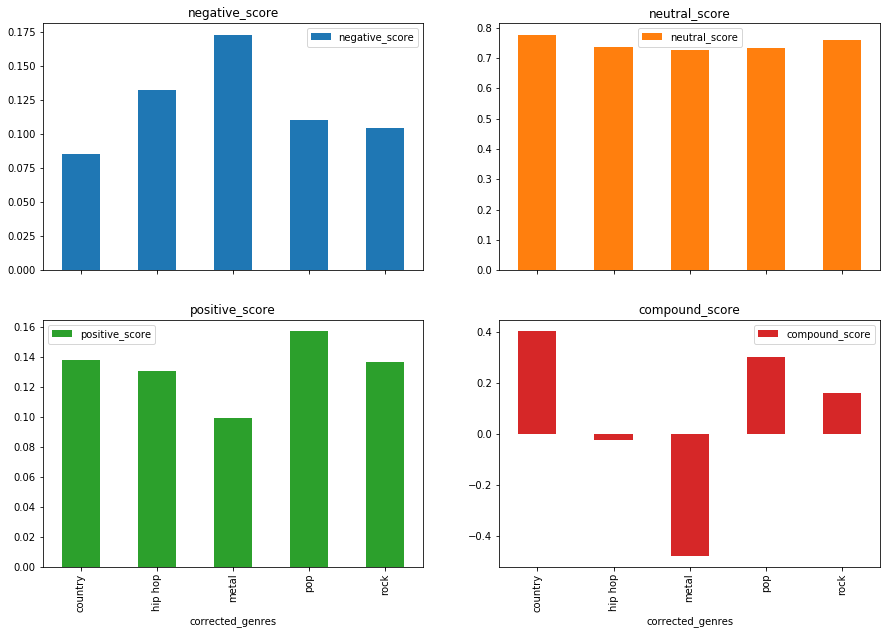

In [79]:
genre_analyze[['negative_score', 'neutral_score', 'positive_score', 'compound_score']].mean().plot.bar(subplots=True, layout=(2,2), figsize=(15,10))

The neutral scores don't have anything interesting going on, so we will ignore those. The compound scores are used to calculate positive, negative and neutral scores. So, compound scores may show similar results from negative and positive scores.<br>
For the negative scores, metal music seems to generally be more negative. Close behind metal is hip-hop.<br>
The most positive genre goes to pop. When I think of pop music, I imagine happy, catchy songs. So, this makes sense.

In [ ]:
#TODO Time series data, and some analysis on that.